# Exploring the Effect of COVID-19 on the Resale Luxury Masks

Panic buying during the COVID-19 pandemic has been prevalent. Stockpiling huge amounts of protective facemasks and cleaning equipment have been on the news often in the past few weeks. I am interested in the effect of COVID-19 on luxury facemasks; Specifically *OFF-WHITE* facemasks. *OFF-WHITE* is a designer streetwear brand that is both expensive and exclusive. *OFF-White* items sell-out relatively fast and are then resold at a profit. One of the biggest marketplaces for streetwear resale is *StockX*. The *StockX* marketplace is the ebay for streetwear; Multiple sellers ask for a price, and bidders bid on the price. Once an asker and a bidder meet at a price, the item is sold. *StockX* stores all the resale activity for an item on the items webpage. With a few lines of code this data becomes easily accessible. Therefore, using the data of two facemasks, that I scraped off of *StockX*, I will attempt to explore the effect of COVID-19 and hopefully find something interesting.

In [1]:
import matplotlib.colors as mplc
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.ticker as plticker
import pandas as pd
import qeds
import json
import seaborn as sns

### Importing the Data

I scraped JSON files, from StockX, for the two([*OFF-WHITE Diag Face Mask (SS19) Black/White*](https://stockx.com/off-white-diag-face-mask-ss19-black-white), [*OFF-WHITE Logo Face Mask (SS19) Black/White*](https://stockx.com/off-white-logo-face-mask-ss19-black-white)) masks that I will be using in this exploration/analysis. I also downloaded 2 Google Trends files to compare the mask data to.

In [2]:
mask1 = json.load(open('/home/jupyter/quantecon-notebooks-datascience/proj/OW_Diag_ss19'))
keys_mask1 = list(mask1.keys())
mask1 = pd.DataFrame(mask1["ProductActivity"])

mask2 = json.load(open('/home/jupyter/quantecon-notebooks-datascience/proj/OW_Logo_ss19'))
keys_mask2 = list(mask2.keys())
mask2 = pd.DataFrame(mask2["ProductActivity"])

googletrendsmask = pd.read_csv(open('/home/jupyter/quantecon-notebooks-datascience/proj/facemask_googletrends.csv'))
googletrendscorona = pd.read_csv(open('/home/jupyter/quantecon-notebooks-datascience/proj/corona_googletrends.csv'))

### Cleaning the Data

The collected mask data has columns that are of no interest to us; I will drop these columns. I will then rename the remaining columns and change the format of the time into one that better suits my analysis. I will merge the two datasets, into a panel data type data frame. I will add a new column as an identifier of which mask the observations are for. I did not merge by column since I will have a lot *NA* values; This is because *createdAt* is date down to the second.

In [3]:
print(list(mask1.columns))

mask1 = mask1[['amount','createdAt']]
mask2 = mask2[['amount', 'createdAt']]

mask1.columns = ['resaleprice', 'dateresold']
mask2.columns = ['resaleprice', 'dateresold']

mask1["name"] = "diag"
mask2["name"] = "logo"

masks = pd.concat([mask1,mask2])
print(masks.name.value_counts())
masks.dtypes

['chainId', 'amount', 'createdAt', 'shoeSize', 'productId', 'skuUuid', 'state', 'customerId', 'localAmount', 'localCurrency']
diag    656
logo    439
Name: name, dtype: int64


resaleprice    float64
dateresold      object
name            object
dtype: object

we can see that the date resold is of type *object*, I will change that into a pandas *datetime* type. The data has the following format:

In [4]:
masks.at[0,"dateresold"]

array(['2020-04-20T22:10:49+00:00', '2020-04-20T16:55:59+00:00'],
      dtype=object)

In [5]:
stockx_date = "%Y-%m-%dT%H:%M:%S+00:00"
masks['dateresold'] = pd.to_datetime(masks['dateresold'], format= stockx_date)
masks = masks.set_index("dateresold")

In [6]:
names = ["diag", "logo"]
masks_ts = (
    masks
    .reset_index()
    .pivot_table(index="dateresold", columns="name", values="resaleprice")
    [names]
)
masks_ts["hour"] = masks_ts.index.hour
masks_ts["day"] = masks_ts.index.dayofweek
print(masks_ts.index.min())

2019-05-28 21:01:53


Now the google data

In [7]:
googletrendscorona['week'] = pd.to_datetime(googletrendscorona['week'], format="%Y-%m-%d")
googletrendscorona = googletrendscorona[(googletrendscorona['week']>pd.Timestamp(2019,4,20))]
googletrendscorona = googletrendscorona.set_index("week")

googletrendsmask['week'] = pd.to_datetime(googletrendsmask['week'], format="%Y-%m-%d")
googletrendsmask = googletrendsmask[(googletrendsmask['week']>pd.Timestamp(2019,4,20))]
googletrendsmask = googletrendsmask.set_index("week")

### Comparing the shift in resale price with Google Trends "corona" and "facemask" search

Lets merge mask data to better visualize the plots.

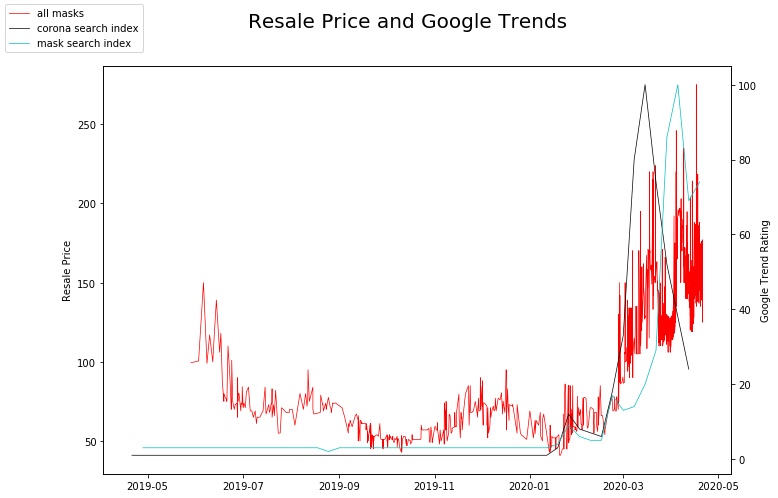

In [8]:
masks_all = masks_ts.copy()
masks_all["all"] = masks_all[["diag","logo"]].sum(axis = 1)
masks_all.reset_index(inplace = True)
masks_all = masks_all[["dateresold","all","hour","day"]]
masks_all.set_index("dateresold", inplace = True)
masks_all

fig, ax = plt.subplots(figsize = (11.25,7.5))
ax1 = ax.twinx()
a, = ax.plot(masks_all[["all"]], "-r", label = "all masks", linewidth = 0.7)
b, = ax1.plot(googletrendscorona, "-k" ,label = "corona search index", linewidth = 0.7)
c, = ax1.plot(googletrendsmask, "-c" ,label = "mask search index", linewidth = 0.7)
p = [a, b, c]
fig.legend(loc = "upper left")
ax.set_ylabel("Resale Price")
ax1.set_ylabel("Google Trend Rating")
fig.suptitle('Resale Price and Google Trends', fontsize=20)
plt.show()

The above graph is messy and includes a lot of unnecessary information. I will subset it and plot a moving average form of the resale price.

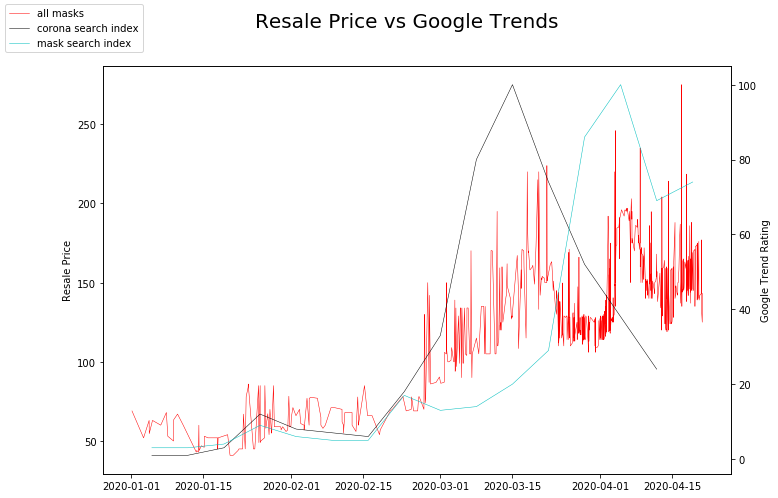

In [9]:
googletrendscorona_ = googletrendscorona[(googletrendscorona.index>pd.Timestamp(2020,1,1))]
googletrendsmask_ = googletrendsmask[(googletrendsmask.index>pd.Timestamp(2020,1,1))]
masks_all2020 = masks_all[(masks_all.index > pd.Timestamp(2020,1,1))]


fig, ax = plt.subplots(figsize = (7.5*1.5,5*1.5))
ax1 = ax.twinx()
a, = ax.plot(masks_all2020[["all"]], "-r", label = "all masks", linewidth = 0.5), 
b, = ax1.plot(googletrendscorona_, "-k" ,label = "corona search index", linewidth = 0.5)
c, = ax1.plot(googletrendsmask_, "-c" ,label = "mask search index", linewidth = 0.5)
p = [a, b, c]
fig.legend(loc = "upper left")
ax.set_ylabel("Resale Price")
ax1.set_ylabel("Google Trend Rating")
fig.suptitle('Resale Price vs Google Trends', fontsize=20)
plt.show()

## Price Premium and Volatility

What about the price premium these items were sold at. i.e. howe much profit/loss did the reseller make?

In [10]:
masks = masks[["resaleprice"]]
masks = masks[(masks.index > pd.Timestamp(2020,1,1))]
masks["retailprice"] = 105
masks["pricepremium"] = (masks["resaleprice"] - masks["retailprice"])/masks["retailprice"]
masks = masks.reset_index()
masks = masks.sort_values('dateresold').set_index('dateresold')
masks["dayof"] = masks.index
masks["dayof"] = pd.to_datetime(masks["dayof"].dt.strftime("%Y-%m-%d"))
masks["4dmean"] = masks["pricepremium"].rolling("4d").mean()

I smooth the graph on a 4 day rolling mean basis to see the long-term trend. We can see it rises as the *Corona* search index rises, but then continues similarly to the *Mask* search index.

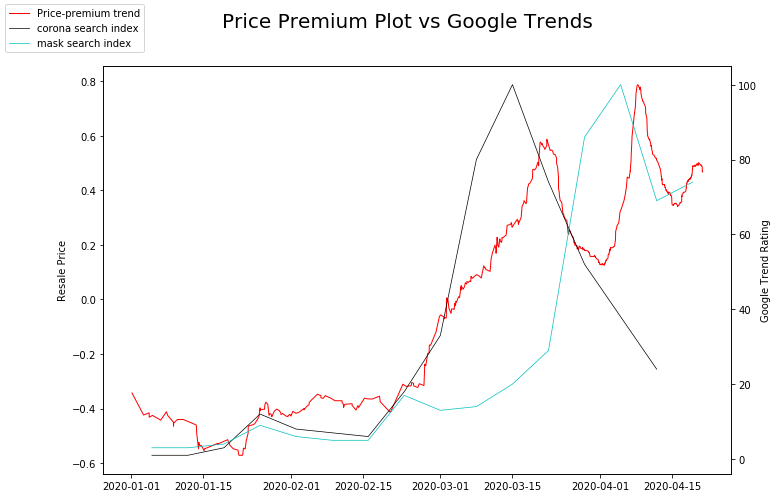

In [11]:
fig, ax = plt.subplots(figsize = (7.5*1.5,5*1.5))
ax1 = ax.twinx()
a, = ax.plot(masks[["4dmean"]], "-r", label = "Price-premium trend", linewidth = 1), 
b, = ax1.plot(googletrendscorona_, "-k" ,label = "corona search index", linewidth = 0.7)
c, = ax1.plot(googletrendsmask_, "-c" ,label = "mask search index", linewidth = 0.7)
p = [a, b, c]
fig.legend(loc = "upper left")
ax.set_ylabel("Resale Price")
ax1.set_ylabel("Google Trend Rating")
fig.suptitle('Price Premium Plot vs Google Trends', fontsize=20)
plt.show()

Lets see how volatility changes, I will calculate it based on a 3 day rolling standard deviation

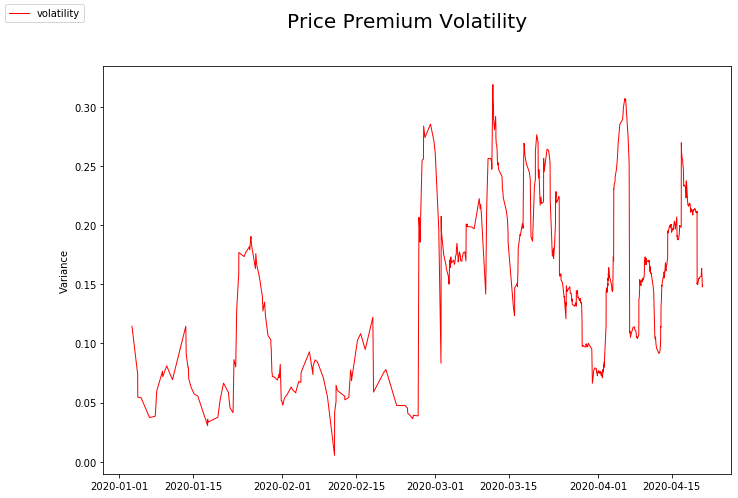

In [12]:
masks["volatility"] = masks["pricepremium"].rolling("3d").std()
masks

fig, ax = plt.subplots(figsize = (7.5*1.5,5*1.5))
ax.plot(masks[["volatility"]], "-r", label = "volatility", linewidth = 1)
fig.legend(loc = "upper left")
ax.set_ylabel("Variance")
fig.suptitle('Price Premium Volatility', fontsize=20)
plt.show()

Volatility was low around April 1st, and high around march 15; Lets take a closer look.

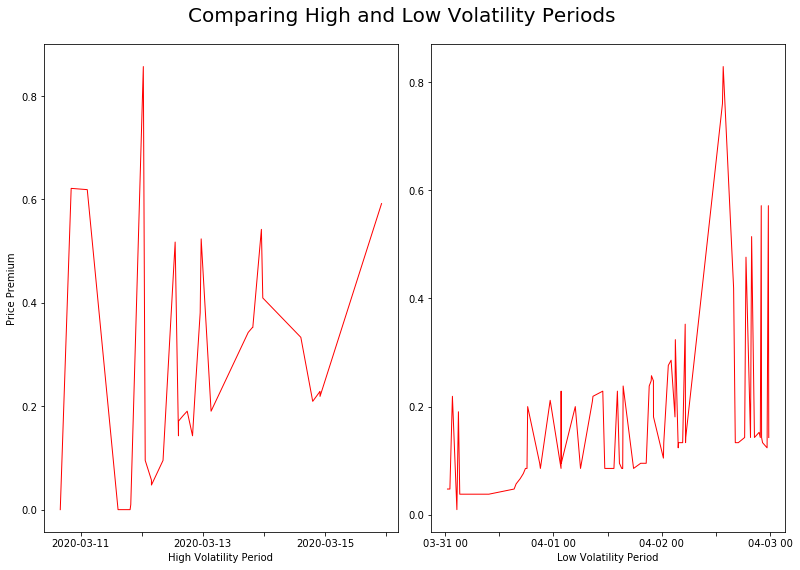

In [13]:
masked1 = masks.loc["March 31, 2020":"April 2, 2020"]
masked2 = masks.loc["March 10, 2020":"March 15, 2020"]



fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (7.5*1.5,5*1.5))
#ax0 = plt.subplot()
ax[0].plot(masked2["pricepremium"], "-r", label = "Price Premium", linewidth = 1)
ax[1].plot(masked1["pricepremium"], "-r", label = "Price Premium", linewidth = 1)

every_nth = 2
for n, label in enumerate(ax[0].xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax[1].xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
ax[0].set_xlabel('High Volatility Period')
ax[1].set_xlabel('Low Volatility Period')
ax[0].set_ylabel('Price Premium')
fig.suptitle('Comparing High and Low Volatility Periods', fontsize=20, y=1.05)
fig.tight_layout()
plt.show()

### What time are people buying masks? Before and after the pandemic

I am curious if the buying habits of people changed after the pandemic. I use february 16 as the start, because that is when the google trends graph in the US started rising.

In [14]:
hour_countstotal = masks_ts.pivot_table(index = ["hour"], columns = ["day"], aggfunc = "size", fill_value = 0)

masks_ts_postcov = masks_ts[(masks_ts.index > pd.Timestamp(2020,2,16))]
masks_ts_precov = masks_ts[(masks_ts.index <= pd.Timestamp(2020,2,15))]

hour_counts_postcov = masks_ts_postcov.pivot_table(index = ["hour"], columns = ["day"], aggfunc = "size", fill_value = 0)
hour_counts_precov = masks_ts_precov.pivot_table(index = ["hour"], columns = ["day"], aggfunc = "size", fill_value = 0)

In [15]:
masks_ts_postcov1 = masks_ts_postcov.copy()
masks_ts_postcov1["mask"] = "mask"
countstotal_bydaypost = masks_ts_postcov1.pivot_table(index = ["mask"], columns = ["day"], aggfunc = "size", fill_value = 0)

masks_ts_precov1 = masks_ts_precov.copy()
masks_ts_precov1["mask"] = "mask"
countstotal_bydaypre = masks_ts_precov1.pivot_table(index = ["mask"], columns = ["day"], aggfunc = "size", fill_value = 0)

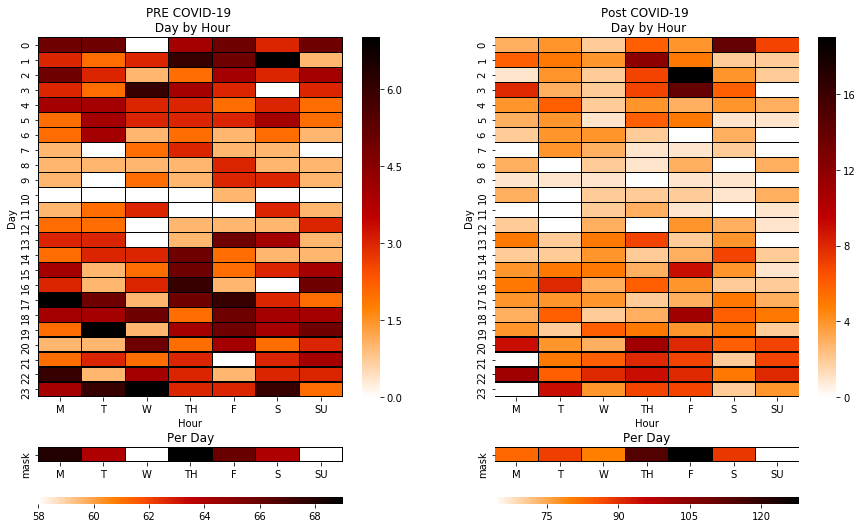

In [16]:
xticklabs = ["M", "T", "W", "TH", "F", "S", "SU"]

fig = plt.figure(figsize=(10*1.5,6*1.5))
gs = gridspec.GridSpec(3,2, height_ratios= [10,1,1])

ax0 = plt.subplot(gs[0])
sns.heatmap(hour_counts_precov, cmap = "gist_heat_r", ax=ax0, linewidths= .05, linecolor='black', xticklabels = xticklabs)

ax1 = plt.subplot(gs[1])
sns.heatmap(hour_counts_postcov, cmap = "gist_heat_r", ax=ax1, linewidths= .05, linecolor='black', xticklabels = xticklabs)

ax2 = plt.subplot(gs[2])
ax5 = plt.subplot(gs[4])
sns.heatmap(countstotal_bydaypre, cmap = "gist_heat_r", ax=ax2, linewidths= .1, linecolor='black', cbar_kws = {"orientation": "horizontal"}, cbar_ax=ax5, xticklabels = xticklabs)
box2 = ax2.get_position()
ax2.set_position([box2.x0, box2.y0, box2.width*0.8 , box2.height * 0.4])

box5 = ax5.get_position()
ax5.set_position([box5.x0, box5.y0+0.035, box5.width*0.8 , box5.height * 0.2])

ax3 = plt.subplot(gs[3])
ax6 = plt.subplot(gs[5])
sns.heatmap(countstotal_bydaypost, cmap = "gist_heat_r", ax=ax3, linewidths= .1, linecolor='black', cbar_kws = {"orientation": "horizontal"}, cbar_ax=ax6, xticklabels = xticklabs)
box3 = ax3.get_position()
ax3.set_position([box3.x0, box3.y0, box3.width*0.8 , box3.height * 0.4])

box6 = ax6.get_position()
ax6.set_position([box6.x0, box6.y0+0.035, box6.width*0.8 , box6.height * 0.2])

##LABS
ax0.set_title('PRE COVID-19 \n Day by Hour')
ax0.set_xlabel('Hour')
ax0.set_ylabel('Day')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Day')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax3.set_xlabel('')
ax3.set_ylabel('')
ax1.set_title('Post COVID-19 \n Day by Hour')
ax3.set_title('Per Day')
ax2.set_title('Per Day')
plt.show()

### How did the number of mask resales change as time progressed?

I will now look at the amount of masks bought as COVID-19 progressed.

In [17]:
masks_ts_jan22 = masks_ts[(masks_ts.index > pd.Timestamp(2020,1,22))].copy()
masks_ts_jan22["monthday"] = masks_ts_jan22.index
masks_ts_jan22["monthday"] = pd.to_datetime(masks_ts_jan22["monthday"].dt.strftime("%Y-%m-%d"))
masks_ts_jan22["mask"] = "mask"
countstotal_bymonthday = masks_ts_jan22.pivot_table(index = ["mask"], columns = ["monthday"], aggfunc = "size", fill_value = 0)

I will plot the graph and see if I can get any information out of it.

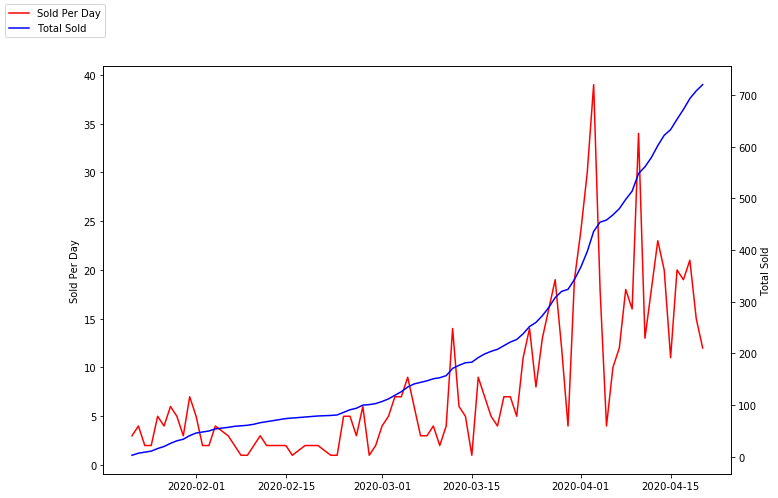

In [18]:
monthdaychangeplots = countstotal_bymonthday.T.copy()
monthdaychangeplots.columns = ['sold per day']
monthdaychangeplots["cumsum"] = monthdaychangeplots["sold per day"].cumsum()
fig, ax = plt.subplots(figsize = (7.5*1.5,5*1.5))
ax1 = ax.twinx()
a, = ax.plot(monthdaychangeplots["sold per day"], "-r", label = "Sold Per Day"), 
b, = ax1.plot(monthdaychangeplots["cumsum"], "-b" ,label = "Total Sold")
p = [a, b]
fig.legend(loc = "upper left")
ax.set_ylabel("Sold Per Day")
ax1.set_ylabel("Total Sold")
plt.show()

Using a heatmap, as the one used above doesn't give us information any better than a barplot does. As demonstrated below.

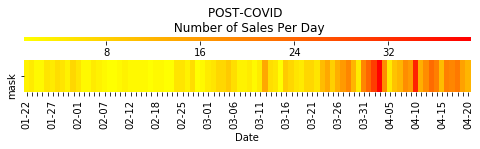

In [19]:
xticks2 = pd.date_range('2020-01-22', periods=90).strftime('%m-%d')
xticks2 = xticks2.values.tolist()
for c in ['02-05', '02-17','02-19','02-21']:
    xticks2.remove(c)

fig = plt.figure(figsize=(8,1))
gs = gridspec.GridSpec(3,1, height_ratios= [1,4,10]) 
ax1 = plt.subplot(gs[0])
ax0 = plt.subplot(gs[2])
sns.heatmap(countstotal_bymonthday, cmap = "autumn_r", cbar_kws = {"orientation": "horizontal", "shrink": 2}, cbar_ax=ax1, ax=ax0, xticklabels = xticks2)


every_nth = 5
for n, label in enumerate(ax0.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        

ax1.set_title('POST-COVID \n Number of Sales Per Day')
ax0.set_xlabel('Date')
ax0.set_ylabel('')

plt.show()

### Growth Rate Along Time

However, [*The New York Times*](https://www.nytimes.com/interactive/2020/world/coronavirus-maps.html) corona virus live feed had an interesting feature next to every countries count cases count; This was a case growth rate that shows how the growth rate for the day compared to the past seven days. I will reattempt to do something similar below. I will compare a single days growth rate with the average of the 7 previous days. I will then classify them as, "Fast", "Faster", "Slow", and "Slower"

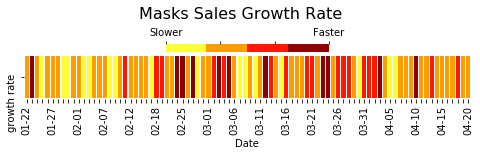

In [20]:
monthdaychange = countstotal_bymonthday.T.copy()
monthdaychange["test"] = monthdaychange["mask"].cumsum()
monthdaychange["test2"] = monthdaychange["test"].shift()
monthdaychange["gr1"] = (monthdaychange["test"]-monthdaychange["test2"])/monthdaychange["test2"]
monthdaychange["gr1"] = monthdaychange["gr1"].fillna(0)
monthdaychange["7daygr"] = monthdaychange["gr1"].rolling("7d").mean(); monthdaychange

def fastslowly(row):
    if row["gr1"] > 1.5*row["7daygr"]:
       x = 4
    elif row["gr1"] > row["7daygr"]:
       x = 3
    elif 2*row["gr1"] < row["7daygr"]:
       x = 1
    elif row["gr1"] <= row["7daygr"]:
       x = 2
    else:
        x = 0
    return x

monthdaychange["growth rate"] = monthdaychange.apply(fastslowly, axis = 1)
monthdaychange[(monthdaychange.index > pd.Timestamp(2020,1,22))]
monthdaychangefs = monthdaychange[["growth rate"]].T.copy()

f, ax = plt.subplots(figsize=(8,1))
sns.heatmap(monthdaychangefs,cmap = sns.color_palette("hot_r", 4), cbar_kws = dict(use_gridspec=False,location="top"), ax=ax, linewidths= .05, xticklabels = xticks2)
cbar = ax.collections[0].colorbar
cbar.set_ticks([1,2,3,4])
cbar.set_ticklabels(["Slower","", "", "Faster"])
ax.set_xlabel('Date')
ax.set_ylabel('')
f.suptitle('Masks Sales Growth Rate', fontsize=16, y=1.4)

#STACK EXCHANGE FUNCTION TO REDUCE TICKS; https://stackoverflow.com/questions/6682784/reducing-number-of-plot-ticks
every_nth = 5
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
plt.show()